In [22]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

## Загрузка и знакомство с данными

Для работы вам понадобятся данные из нашего учебного конкурса на kaggle [«Прогноз популярности статьи на Хабре»](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). Скачайте файл **`howpop_train.csv`** и положите его в папку **`data`**:

In [7]:
df = pd.read_csv('/Users/iakubovskii/Machine_Learning/RANEPA/Data/howpop_train.csv')

In [8]:
df.shape

(134137, 17)

In [9]:
df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


Избавимся сразу от переменных, названия которых заканчиваются на `_lognorm` (нужны для соревнования на Kaggle). Выберем их с помощью `filter()` и удалим `drop`-ом:

In [10]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: столбцы 
        inplace = True) # избавляет от необходимости сохранять датасет

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.0,115565.0,182666.0,257401.0,314088.0
content_len,134137.0,7516.929699,8724.771640,1.0,2179.0,4949.0,9858.0,352471.0
comments,134137.0,39.625994,62.398958,0.0,7.0,19.0,48.0,2266.0
favs,134137.0,71.999866,145.854135,0.0,8.0,27.0,78.0,8718.0
views,134137.0,16631.013084,31479.819691,3.0,2100.0,7600.0,18700.0,1730000.0
votes_plus,133566.0,35.536888,42.461073,0.0,11.0,22.0,45.0,1466.0
votes_minus,133566.0,8.050035,11.398282,0.0,2.0,5.0,10.0,445.0


In [12]:
df.describe(include = ['object', 'bool'] # бинарные и категориальные переменные
           ).T

,count,unique,top,freq
url,134137,134137,https://habrahabr.ru/company/kaspersky/blog/13...,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,97657,22077,@alizar,5292
flow,97048,6,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [13]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Столбец **`published`** (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу `datetime`:

In [14]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst = True)
print(df.published.dtype)

object
datetime64[ns]


Создадим несколько столбцов на основе данных о времени публикации:

In [15]:
df['year'] = [d.year for d in df.published]
df['month'] = [d.month for d in df.published]

df['dayofweek'] = [d.isoweekday() for d in df.published]
df['hour'] = [d.hour for d in df.published]

-----

## 1\. В каком месяце (какого года) было больше всего публикаций?

In [16]:
df['mon_yr'] = [str(p)[:7] for p in df.published]

In [17]:
print(df.mon_yr.value_counts()[:10])
popmon = df.mon_yr.value_counts().index[0]
print(popmon)

2015-03    2189
2016-03    2115
2015-07    2111
2015-04    2110
2015-12    2084
2015-11    2035
2015-10    2030
2015-06    2004
2015-09    1944
2016-04    1910
Name: mon_yr, dtype: int64
2015-03


- март 2016
- **март 2015**
- апрель 2015
- апрель 2015
 
 
 


## 2\. Проанализируйте публикации в этом месяце

Выберите один или несколько вариантов:

* **На графике не заметны какие-либо выбросы или аномалии,**
* Один или несколько дней сильно выделяются из общей картины,
* На хабре _всегда_ больше статей, чем на гиктаймсе,
* **По субботам на гиктаймс и на хабрахабр публикуют примерно одинаковое число статей.**

Подсказки: постройте график зависимости числа публикаций от дня; используйте параметр `hue`; не заморачивайтесь сильно с ответами и не ищите скрытого смысла :)

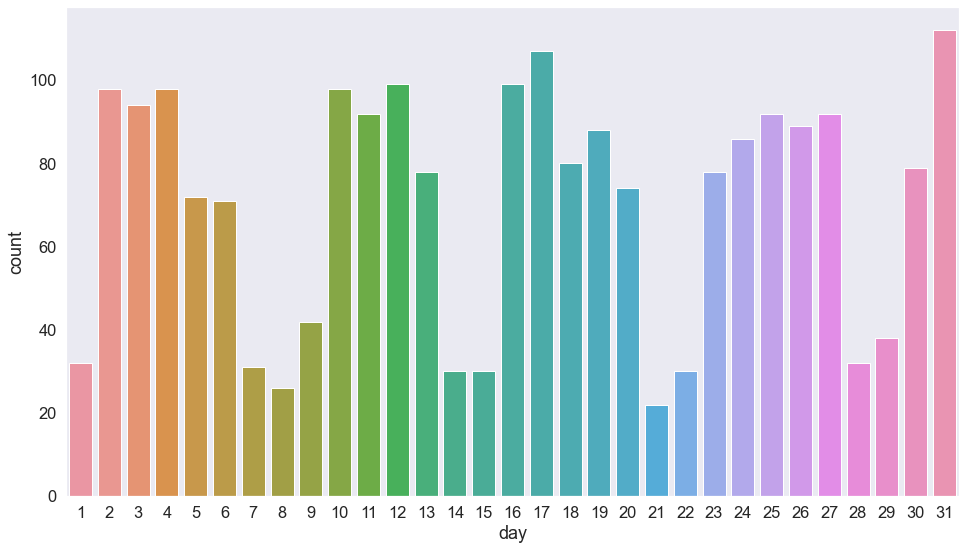

In [23]:
df_popmonth = df[df.mon_yr == popmon]
df_popmonth['day'] = [p.day for p in df_popmonth.published]

sns.countplot(x = 'day', data = df_popmonth);

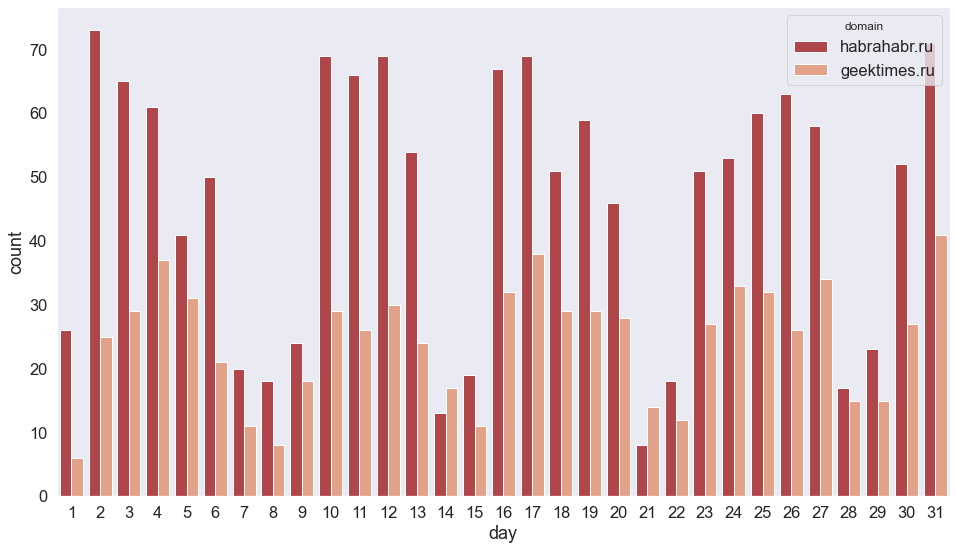

In [24]:
sns.countplot(x = 'day', hue = 'domain', data = df_popmonth);

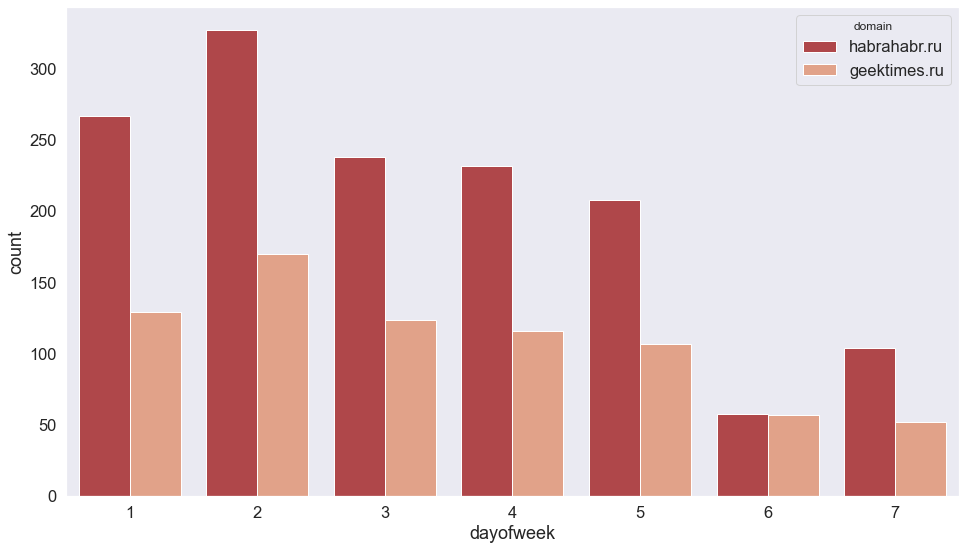

In [25]:
sns.countplot(x = 'dayofweek', hue = 'domain', data = df_popmonth);

## 3\. Когда лучше всего публиковать статью?

* Больше всего просмотров набирают статьи, опубликованные в 12 часов дня;
* **Больше всего просмотров набирают статьи, опубликованные в 6 часов утра;**
* У опубликованных в 10 утра постов больше всего комментариев;
* Максимальное число комментариев на гиктаймсе набрала статья, опубликованная в 10 утра.

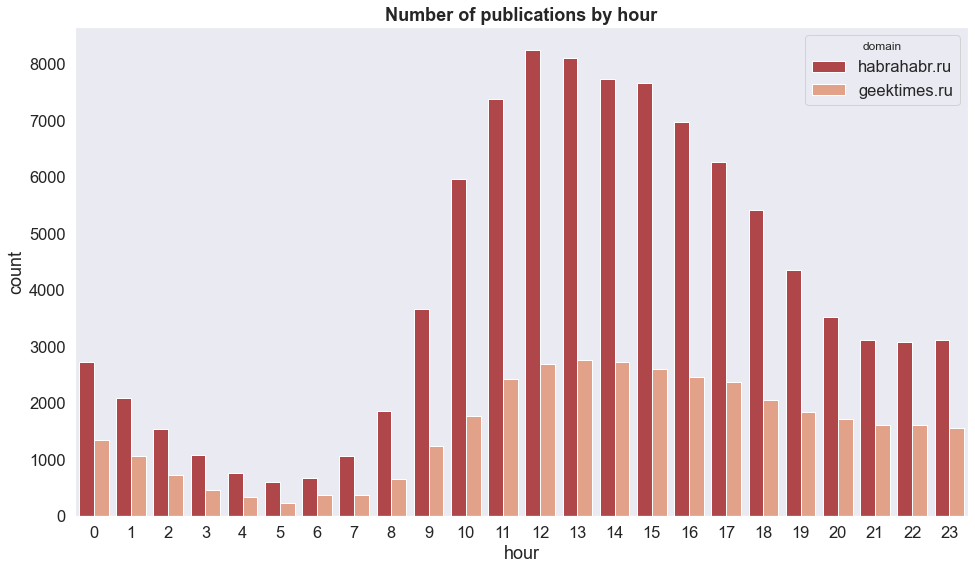

In [27]:
g = sns.countplot(x = 'hour', hue = 'domain', data = df);
g.set_title("Number of publications by hour", fontweight = 'bold');

hour
6     21354.310115
4     20678.389091
7     19093.953408
3     18370.017972
22    18365.387460
Name: views, dtype: float64


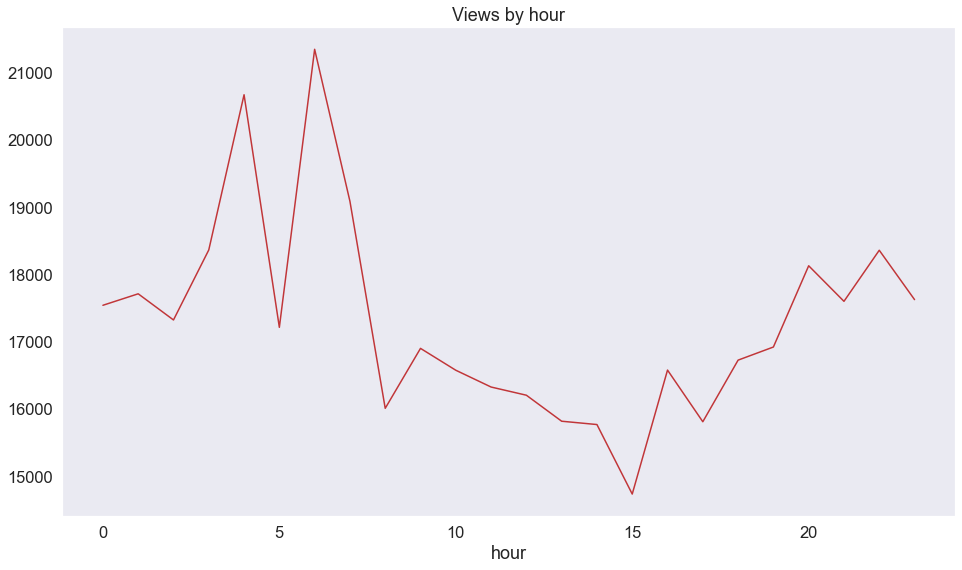

In [28]:
print(df.groupby('hour')['views'].mean().sort_values(ascending=False)[:5])
df.groupby('hour')['views'].mean().plot(title = 'Views by hour');

hour
4    53.657273
3    53.123877
6    51.799618
1    49.417910
2    48.827025
Name: comments, dtype: float64


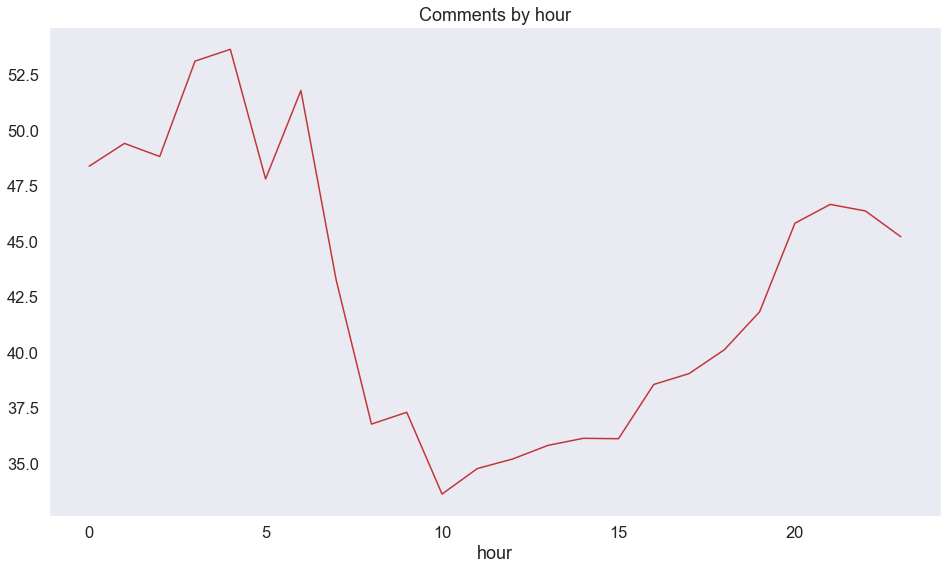

In [29]:
print(df.groupby('hour')['comments'].mean().sort_values(ascending=False)[:5])
df.groupby('hour')['comments'].mean().plot(title = 'Comments by hour');

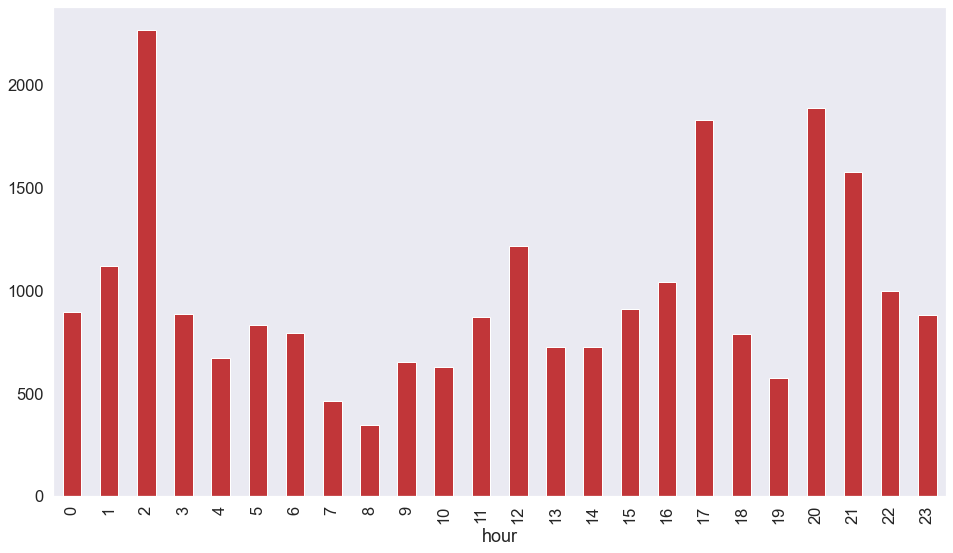

In [40]:
df[df.domain == 'geektimes.ru'].groupby('hour')['comments'].max().plot(kind = "bar")

## 4\. Кого из топ-20 авторов чаще всего минусуют?

* @Mordatyj
* **@Mithgol**
* @alizar
* @ilya42

In [20]:
df[df.author.isin(['@Mordatyj', 
                   '@Mithgol', '@alizar', '@ilya42'])].groupby('author')[['votes_minus']].mean().sort_values('votes_minus', 
                                                                                                             ascending = False)

,votes_minus
author,
@Mithgol,20.481081
@alizar,7.928191
@Mordatyj,7.471455
@ilya42,6.216797


## 5\. Сравните субботы и понедельники

Правда ли, что по субботам авторы пишут в основном днём, а по понедельникам — в основном вечером?

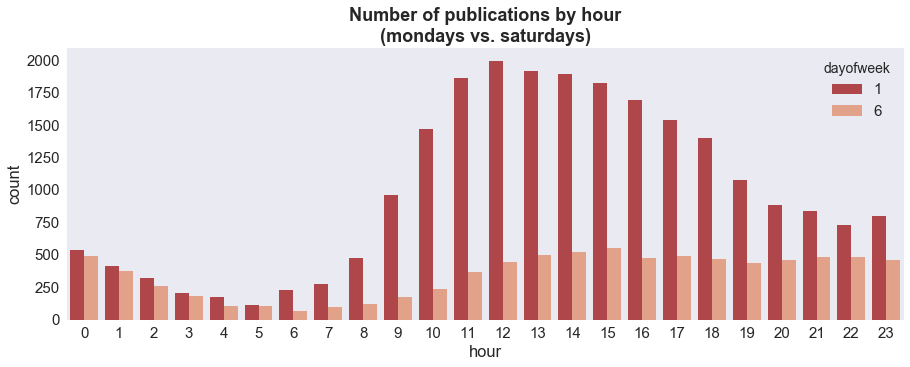

In [21]:
g = sns.countplot(x = 'hour', hue = 'dayofweek', data = df[df.dayofweek.isin([1, 6])]);
g.set_title("Number of publications by hour\n(mondays vs. saturdays)", fontweight = 'bold');

**Ответ: нет.**